# Customer Churn Case Study

### PROBLEM STATEMENT
Predict behavior to retain customers. You can analyze all relevant customer data anddevelop focused customer retention programs.
In other words, create a model that is able to predict customers that will churn

For this project, we will evaluate several classification models and choose the one which best suits our needs.

We would also be logging this experiment on comet ML to help keep track and monitor several versions of the project. Click [here](https://www.comet.ml/othuke/customer-churn) to access the project on comet_ml

In [2]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="CpBbrbaITy6jSvSwej7kzvX7v",
    project_name="customer-churn",
    workspace="othuke",
)
experiment.set_name('Preprocessing')

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/othuke/customer-churn/b62a05d9443446e38d8233ac0f685198
COMET INFO:   Uploads:
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Othuke (Local)\\OneDrive - Trium Limited\\Documents\\CORONATION\\Python\\Othuke Ajaye' nor in any parent directory. You can over

In [3]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
pd.set_option("display.max_columns", None)#display all columns
pd.options.mode.chained_assignment=None #ignore copy warning

In [4]:
# load dataset
df = pd.read_excel('Telco_customer_churn.xlsx')
df.sample(5) # view a random sample of the dataset

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
6147,8099-MZPUJ,1,United States,California,Carmel,93923,"36.460611, -121.852507",36.460611,-121.852507,Male,No,Yes,Yes,48,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),111.80,5443.65,No,0,57,3922,NaN
1102,2034-CGRHZ,1,United States,California,San Francisco,94104,"37.791222, -122.402241",37.791222,-122.402241,Male,Yes,No,No,24,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),102.95,2496.7,Yes,1,66,5245,Competitor offered higher download speeds
2986,6198-RTPMF,1,United States,California,Oregon House,95962,"39.342587, -121.249833",39.342587,-121.249833,Female,No,Yes,No,17,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Electronic check,92.60,1579.7,No,0,32,4756,NaN
4585,6656-JWRQX,1,United States,California,San Diego,92124,"32.827238, -117.089287",32.827238,-117.089287,Female,No,No,No,1,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Mailed check,30.55,30.55,No,0,57,5565,NaN
6190,3410-MHHUM,1,United States,California,San Francisco,94111,"37.801776, -122.402293",37.801776,-122.402293,Female,No,Yes,Yes,44,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,Yes,One year,No,Electronic check,94.40,4295.35,No,0,73,5019,NaN


In [ ]:
# Explore the dataset
df.info()

We can note from here that the Total Charges column has an object data type instead of a float and so we would change that

In [5]:
# convert Total charges feature from object to float
df['Total Charges']= pd.to_numeric(df['Total Charges'], errors='coerce')

In [ ]:
# check missing values
df.isna().mean()

 We notice from here that two columns have missing values.
 * The Total Charges have some missing values which is just about 0.15% of the entire data. This is quite inconsequential so we would drop those rows
 * The Churn Reason on the other hand has about 73% of values missing. That is however because it is only customers that churned that would have a reason for churning. We would drop the whole column as it is not neede for our model anyway.

In [6]:
# drop rows with missing values in Total Charges feature
df = df.drop(df[df['Total Charges'].isna()].index)

# drop churn reason feature
df.drop('Churn Reason', axis=1, inplace=True)

In [ ]:
# describe numerical features
df.describe()

In [ ]:
# Explore the type of data in each column
for i in df.columns:
    print(df[i].value_counts())
    print(60*'=')
    print('\n')

We can see from this information that not all the columns would be needed for the model so we drop the other columns

* The CustomerID column is removed because its a unique value for identification for each customer and has no effect on our model.
* The count column contains only one value. 
* The location data is also removed because they are not very useful for the classification model we want to build.
* Being a classification model, our target would be the churn value. The churn label is also dropped because it is basically the categorical representation of the churn value feature

In [7]:
# Remove unwanted features
cols = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude','Churn Label']
df.drop(cols,axis=1,inplace=True)

In [8]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
train,test = train_test_split(df, random_state=100, test_size=0.2)

In [ ]:
# Inspect the shape of our data
print('The shape of the train data is ',train.shape)
print('The shape of the test data is ',test.shape)

## EXPLORATORY DATA ANALYSIS

Now we explore the various features of the data. First, we look at the target variable

0    0.734215
1    0.265785
Name: Churn Value, dtype: float64


{'web': 'https://www.comet.ml/api/image/download?imageId=00723467b0e944eca8a259bd7dfe315c&experimentKey=6a3e80a1f43747259017692c42e6535d',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=00723467b0e944eca8a259bd7dfe315c&experimentKey=6a3e80a1f43747259017692c42e6535d',
 'imageId': '00723467b0e944eca8a259bd7dfe315c'}

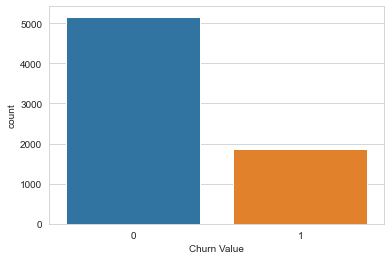

In [9]:
# Explore the target variable with a count plot
print(df['Churn Value'].value_counts(normalize=True))
sns.countplot(x='Churn Value', data=df)
experiment.log_figure(figure_name = 'Label')

We notice here that we have an imbalanced target with ratio of about 73.5 to 26.5

We can balance this using SMOTE resampling technique and using f1 score as our metric for evaluation 

Before that, let us explore the rest of the dataset

{'web': 'https://www.comet.ml/api/image/download?imageId=1d7b6502f57445d591baf7dfae6f3119&experimentKey=6a3e80a1f43747259017692c42e6535d',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=1d7b6502f57445d591baf7dfae6f3119&experimentKey=6a3e80a1f43747259017692c42e6535d',
 'imageId': '1d7b6502f57445d591baf7dfae6f3119'}

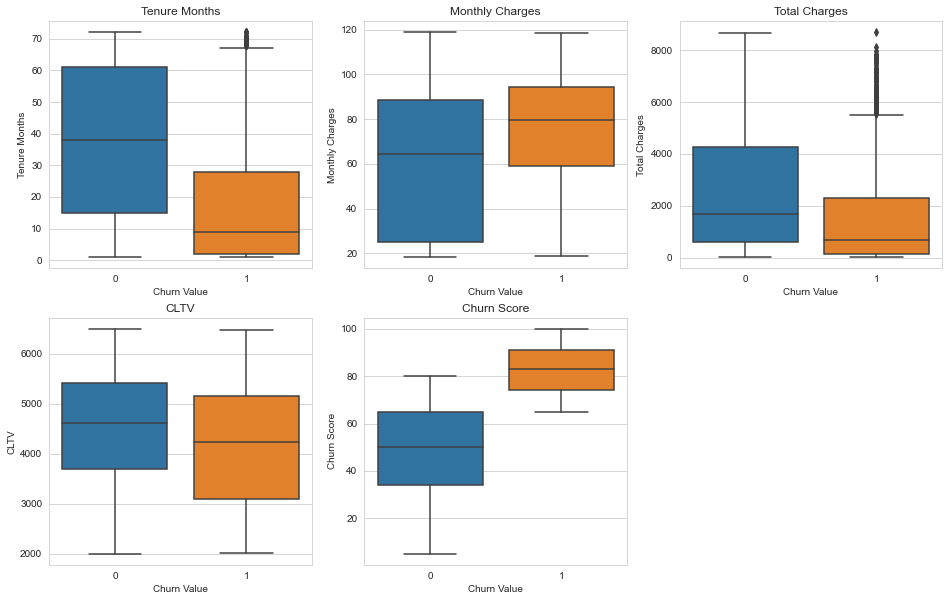

In [10]:
#Explore numerical columns with a boxplot
plt.figure(figsize=(16,10))
for i,j in enumerate(['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV', 'Churn Score']):
    plt.subplot(2,3,i+1)
    sns.boxplot(data=train, y=j, x='Churn Value').set_title(j)
experiment.log_figure(figure_name = 'box plot')


### PLOT INSIGHTS
* Customers who churned spend moch less time with company with a median of about 10 months compared to about 38 for the customers who did not churn.
* Customers who churned are charged a bit higher with a median of about 80 compared to about 64 for non-churners
* The total charges feature is a combination of the monthly charge and tenure month
* We see clearly also that customers with higher churn scores are most likely to churn

{'web': 'https://www.comet.ml/api/image/download?imageId=0003f9baa3454929a376c0300684b499&experimentKey=6a3e80a1f43747259017692c42e6535d',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=0003f9baa3454929a376c0300684b499&experimentKey=6a3e80a1f43747259017692c42e6535d',
 'imageId': '0003f9baa3454929a376c0300684b499'}

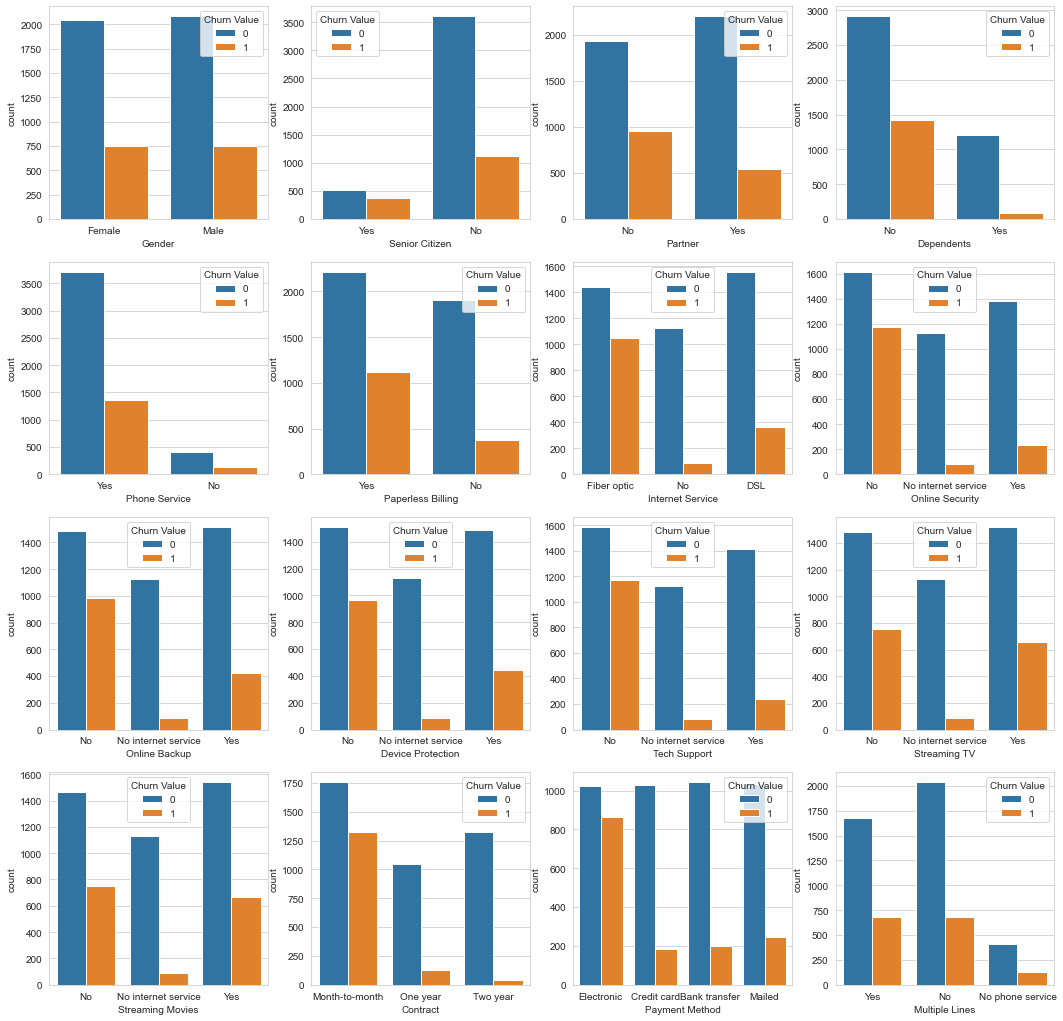

In [11]:
#Create count plots for other categorical columns
cols = ['Gender','Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing','Internet Service', 
        'Online Security','Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies','Contract',
        'Payment Method','Multiple Lines']

#replacing values in the payment method column for easier visualization
train.replace({'Electronic check': 'Electronic', 'Mailed check':'Mailed',
                            'Bank transfer (automatic)':'Bank transfer','Credit card (automatic)':'Credit card' }
                             , inplace=True)

test.replace({'Electronic check': 'Electronic', 'Mailed check':'Mailed',
                            'Bank transfer (automatic)':'Bank transfer','Credit card (automatic)':'Credit card' }
                             , inplace=True)
plt.figure(figsize=(18,18))
for i,j in enumerate(cols):
    plt.subplot(4,4,i+1)
    sns.countplot(x=j, data=train, hue='Churn Value')
experiment.log_figure(figure_name = 'Categorical plots')

### PLOT INSIGHTS

* There are not so many senior citizens amongst the customers but the rate of churn amongst the senior citizens is relatively higher.
* Those with patners and dependents have lower churn rates than those who dont have
* The churn rate for people that use fibre optic internet service is significantly higher
* Customers who don't have online security, online backup, device protection and tech support also have significantly higher churn rates
* Customers whose contracts are on an annual or a two-year basis seem to have significantly lower churn rate than theor counterpart
* Customers who use the electronic method of payment have a much higher churn rate than others


{'web': 'https://www.comet.ml/api/image/download?imageId=e5a7713ff64a4c3c9d2969acabe6a5a2&experimentKey=6a3e80a1f43747259017692c42e6535d',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=e5a7713ff64a4c3c9d2969acabe6a5a2&experimentKey=6a3e80a1f43747259017692c42e6535d',
 'imageId': 'e5a7713ff64a4c3c9d2969acabe6a5a2'}

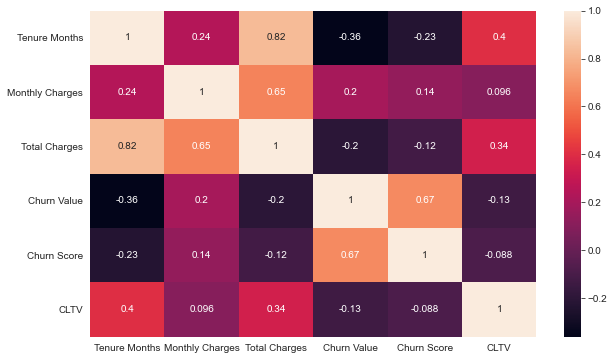

In [12]:
#check correlation of numerical variables
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), annot=True)
experiment.log_figure(figure_name = 'Correlation')

### PLOT INSIGHTS

* We can observe that Tenure months and Total charges are highly correlated. This is expected because the higher the number of months a customer spends with the company, the higher the total chargee they would have acccumulated over those months.
* To avoid multicollinearity, the Total Charges column would be dropped considering also that we have a column for monthly charges

In [13]:
# drop Total Charges feature to avoid collinearity
train.drop('Total Charges', axis=1, inplace=True)
test.drop('Total Charges', axis=1, inplace=True)

In [14]:
#Encode categorical columns for both train and test set
#yes/no columns with label encoder, 0:No, 1:yes
yes_cols = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
for i in yes_cols:
    train[i] = train[i].map({'Yes':1, 'No':0})
    test[i] = test[i].map({'Yes':1, 'No':0})
    
#Encode gender column using label encoder
train['Gender'] =train['Gender'].map({'Female':1, 'Male':0})
test['Gender'] = test['Gender'].map({'Female':1, 'Male':0})

#Encode other categorical columns using one hot encoder
ohe_cols = ['Internet Service', 'Contract','Payment Method','Multiple Lines','Online Security',
            'Online Backup', 'Device Protection','Tech Support','Streaming TV','Streaming Movies']
train = pd.get_dummies(train, columns=ohe_cols,drop_first=True)
test = pd.get_dummies(test, columns=ohe_cols,drop_first=True)

In [15]:
# declare dependent and independent variables
x_train = train.drop('Churn Value', axis=1)
x_test = test.drop('Churn Value', axis=1)

y_train = train['Churn Value']
y_test = test['Churn Value']

In [ ]:
!pip install imblearn

In [16]:
#resampling our data using SMOTE
from imblearn.over_sampling import SMOTE
x_train,y_train = SMOTE().fit_resample(x_train,y_train)
x_test,y_test = SMOTE().fit_resample(x_test,y_test)
x_train.shape

(8254, 31)

In [17]:
# scale selected features using minmax scaler to align with the values of other columns
col = ['Monthly Charges','CLTV','Tenure Months','Churn Score']
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_train[col] = mms.fit_transform(x_train[col])
x_test[col] = mms.transform(x_test[col])

In [19]:
experiment.end()

### MODEL SELECTION
The models selected for this project include:
* Logistic Regression
* Random Forest classifier
* Decision Tree classifier
* K Nearest Neighbours
* Support Vector Machine

### LOGISTIC REGRESSION

In [21]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="CpBbrbaITy6jSvSwej7kzvX7v",
    project_name="customer-churn",
    workspace="othuke"
)

experiment.set_name('logistic_regression')

#import algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score

#instantiate and train algorithm with train dataset
lr = LogisticRegression()
lr.fit(x_train,y_train)

#Make predictions with trained model on test dataset and view metrics
y_pred = lr.predict(x_test)
report = classification_report(y_test,y_pred, output_dict=True)
matrix = confusion_matrix(y_test,y_pred)

metrics = {'Accuracy': accuracy_score(y_test,y_pred), 'Precision': precision_score(y_test,y_pred),
          'f1_score': f1_score(y_test,y_pred)} 

experiment.log_metrics(metrics)
experiment.log_confusion_matrix(y_test.tolist(), y_pred.tolist())

#print(report)
#print(matrix)
lr_acc = accuracy_score(y_test,y_pred)
lr_f1 = f1_score(y_test,y_pred)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Othuke (Local)\\OneDrive - Trium Limited\\Documents\\CORONATION\\Python\\Othuke Ajaye' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/othuke/customer-churn/d3bd71cda0b045678ff82085b07af4eb



### RANDOM FOREST CLASSIFIER

In [34]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="CpBbrbaITy6jSvSwej7kzvX7v",
    project_name="customer-churn",
    workspace="othuke"
)

experiment.set_name('random_forest_classifier')
#import algorithm
from sklearn.ensemble import RandomForestClassifier

#instantiate and train algorithm with train dataset
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

#Make predictions with trained model on test dataset and view metrics
y_pred = rf.predict(x_test)
report = classification_report(y_test,y_pred, output_dict=True)
matrix = confusion_matrix(y_test,y_pred)

metrics = {'Accuracy_rf': accuracy_score(y_test,y_pred), 'Precision_rf': precision_score(y_test,y_pred),
          'f1_score_rf': f1_score(y_test,y_pred)} 

experiment.log_metrics(metrics)
experiment.log_confusion_matrix(y_test.tolist(), y_pred.tolist())

config = {
    "algorithm": "random",
    "name": "Optimize random forest model",
    "spec": {"maxCombo": 10, "objective": "minimize", "metric": "loss"},
    "parameters": {'max_depth': [7, 15],
             'n_estimators': [10, 100, 500,1000],
             'random_state': [7,10],
             'min_samples_split': [5],
            'max_features' : ['sqrt', 'log2']},
    "trials": 1,
}
opt = comet_ml.Optimizer(config)

for experiment in opt.get_experiments(api_key="CpBbrbaITy6jSvSwej7kzvX7v",
    project_name="customer-churn",
    workspace="othuke"):
    max_depth = experiment.get_parameter("max_depth"),
    n_estimators = experiment.get_parameter("n_estimators"),
    random_state = experiment.get_parameter("random_state"),
    min_samples_split = experiment.get_parameter("min_samples_split"),
    max_features = experiment.get_parameter("max_features")
    
    rf_opt = RandomForestClassifier(max_depth = experiment.get_parameter("max_depth"),
                                    n_estimators = experiment.get_parameter("n_estimators"),
                                    random_state = experiment.get_parameter("random_state"),
                                    min_samples_split = experiment.get_parameter("min_samples_split"),
                                    max_features = experiment.get_parameter("max_features"))
    rf_opt.fit(x_train, y_train)
    y_pred = rf.predict(x_test)

    metrics = {'Accuracy_rf_opt': accuracy_score(y_test,y_pred), 'Precision_rf_opt': precision_score(y_test,y_pred),
              'f1_score_rf_opt': f1_score(y_test,y_pred)} 
    
    experiment.log_metrics(metrics)
    experiment.log_confusion_matrix(y_test.tolist(), y_pred.tolist())
    
    experiment.end()

rf_acc = accuracy_score(y_test,y_pred)
rf_f1 = f1_score(y_test,y_pred)


COMET ERROR: Optimizer couldn't end
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/othuke/customer-churn/51a872350c024b08b13b7b5a0397a211
COMET INFO:   Others:
COMET INFO:     optimizer_id    : a5d6c1b3d3bd422eb24f9c85a8359205
COMET INFO:     optimizer_pid   : 5b7e40330ffc3c0440c7a9e9b43a62a9b64a6d56
COMET INFO:     optimizer_trial : 1
COMET INFO:   Parameters:
COMET INFO:     max_depth         : 7
COMET INFO:     max_features      : sqrt
COMET INFO:     min_samples_split : 5
COMET INFO:     n_estimators      : 500
COMET INFO:     random_state      : 10
COMET INFO:   Uploads:
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     noteb

COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Othuke (Local)\\OneDrive - Trium Limited\\Documents\\CORONATION\\Python\\Othuke Ajaye' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/othuke/customer-churn/2e1ca1b1b4d146e3a39efa434865ba0b

COMET INFO: Optimizer metrics is 'loss' but no logged values found. Experiment ignored in sweep.
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/othuke/customer-churn/2e1ca1b1b4d146e3a39efa434865ba0b
COMET INFO:   Metrics:
COMET INFO:     Accuracy_rf_opt  : 0.9324324324324325
COMET INFO:     Precision_rf_opt : 0.9226415094339623
COMET INFO:     f1_score_rf_opt  : 0.933206106870229
COMET INFO:   Others

COMET INFO:     optimizer_process      : 23556
COMET INFO:     optimizer_trial        : 1
COMET INFO:     optimizer_version      : 2.0.1
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_weight             : 1
COMET INFO:     criterion                : gini
COMET INFO:     max_depth                : 7
COMET INFO:     max_features             : sqrt
COMET INFO:     max_leaf_nodes           : 1
COMET INFO:     max_samples              : 1
COMET INFO:     min_impurity_decrease    : 0.0
COMET INFO:     min_samples_leaf         : 1
COMET INFO:     min_samples_split        : 5
COMET INFO:     min_weight_fraction_leaf : 0.0
COMET INFO:     n_estimators             : 500
COMET INFO:     n_jobs                   : 1
COMET INFO:     oob_score                : False
COMET INFO:     random_state             : 7
COMET INFO:     splitter                 : best
COMET INFO:     verbose                  : 0
COM

COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 59.21 KB/94.46 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Othuke (Local)\\OneDrive - Trium Limited\\Documents\\CORONATION\\Python\\Othuke Ajaye' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/othuke/customer-churn/175b4feb46b1442a95ce2396e1aed285

COMET INFO: Optimizer m

COMET INFO:   Metrics:
COMET INFO:     Accuracy_rf_opt  : 0.9324324324324325
COMET INFO:     Precision_rf_opt : 0.9226415094339623
COMET INFO:     f1_score_rf_opt  : 0.933206106870229
COMET INFO:   Others:
COMET INFO:     optimizer_count        : 9
COMET INFO:     optimizer_id           : a71b2c130f824249be5807c3c06151a4
COMET INFO:     optimizer_metric       : loss
COMET INFO:     optimizer_metric_value : 1
COMET INFO:     optimizer_name         : Optimize random forest model
COMET INFO:     optimizer_objective    : minimum
COMET INFO:     optimizer_parameters   : {"max_depth": 15, "max_features": "sqrt", "min_samples_split": 5, "n_estimators": 10, "random_state": 7}
COMET INFO:     optimizer_pid          : f503e1d2c44b6a739bcb1683b0200992b81d4c3d
COMET INFO:     optimizer_process      : 23556
COMET INFO:     optimizer_trial        : 1
COMET INFO:     optimizer_version      : 2.0.1
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha     

### DECISION TREE CLASSIFIER

In [23]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="CpBbrbaITy6jSvSwej7kzvX7v",
    project_name="customer-churn",
    workspace="othuke"
)

experiment.set_name('decision_tree_classifier')
#import algorithm
from sklearn.tree import DecisionTreeClassifier

#instantiate and train algorithm with train dataset
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

#Make predictions with trained model on test dataset and view metrics
y_pred = dt.predict(x_test)
report = classification_report(y_test,y_pred, output_dict=True)
matrix = confusion_matrix(y_test,y_pred)

metrics = {'Accuracy': accuracy_score(y_test,y_pred), 'Precision': precision_score(y_test,y_pred),
          'f1_score': f1_score(y_test,y_pred)} 

experiment.log_metrics(metrics)
experiment.log_confusion_matrix(y_test.tolist(), y_pred.tolist())
experiment.end()


dt_acc = accuracy_score(y_test,y_pred)
dt_f1 = f1_score(y_test,y_pred)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Othuke (Local)\\OneDrive - Trium Limited\\Documents\\CORONATION\\Python\\Othuke Ajaye' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/othuke/customer-churn/5210fc61a02f42cd8ad9cd0fd0695f14

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/othuke/customer-churn/5210fc61a02f42cd8ad9cd0fd0695f14
COMET INFO:   Metrics:
COMET INFO:     Accuracy  : 0.9136100386100386
COMET INFO:     Precision : 0.923837784371909
COMET INFO: 

### K NEAREST NEIGHBOUR

In [25]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="CpBbrbaITy6jSvSwej7kzvX7v",
    project_name="customer-churn",
    workspace="othuke"
)

experiment.set_name('k-nearest neighbor')
#import algorithm
from sklearn.neighbors import KNeighborsClassifier

#instantiate and train algorithm with train dataset
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

#Make predictions with trained model on test dataset and view metrics
y_pred = knn.predict(x_test)
metrics = {'Accuracy': accuracy_score(y_test,y_pred), 'Precision': precision_score(y_test,y_pred),
          'f1_score': f1_score(y_test,y_pred)} 

experiment.log_metrics(metrics)
experiment.log_confusion_matrix(y_test.tolist(), y_pred.tolist())
experiment.end()

knn_acc = accuracy_score(y_test,y_pred)
knn_f1 = f1_score(y_test,y_pred)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/othuke/customer-churn/f860155fd8f64e8093ecafc85b28b612
COMET INFO:   Uploads:
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Othuke (Local)\\OneDrive - Trium Limited\\Documents\\CORONATION\\Python\\Othuke Ajaye' nor in any parent directory. You can override where Comet is looking for a Git Pa

### SUPPORT VECTOR MACHINE

In [26]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="CpBbrbaITy6jSvSwej7kzvX7v",
    project_name="customer-churn",
    workspace="othuke"
)

experiment.set_name('support_vector_machine')

#import algorithm
from sklearn.svm import SVC

#instantiate and train algorithm with train dataset
svc = SVC()
svc.fit(x_train,y_train)

#Make predictions with trained model on test dataset and view metrics
y_pred = svc.predict(x_test)
metrics = {'Accuracy': accuracy_score(y_test,y_pred), 'Precision': precision_score(y_test,y_pred),
          'f1_score': f1_score(y_test,y_pred)} 

experiment.log_metrics(metrics)
experiment.log_confusion_matrix(y_test.tolist(), y_pred.tolist())
experiment.end()


svc_acc = accuracy_score(y_test,y_pred)
svc_f1 = f1_score(y_test,y_pred)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Othuke (Local)\\OneDrive - Trium Limited\\Documents\\CORONATION\\Python\\Othuke Ajaye' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/othuke/customer-churn/f5213ef5da1b474c9a0ba81833cc5935

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/othuke/customer-churn/f5213ef5da1b474c9a0ba81833cc5935
COMET INFO:   Metrics:
COMET INFO:     Accuracy  : 0.9261583011583011
COMET INFO:     Precision : 0.9153339604891816
COMET INFO:

In [ ]:
# create a dataframe to compare and contrast the accuracy and f1 score of the models
score = pd.DataFrame({'Logistic Regression':[lr_acc, lr_f1],
'Random Forest classifier':[rf_acc, rf_f1],
'Decision Tree classifier':[dt_acc, dt_f1],
'K Nearest Neighbours':[knn_acc, knn_f1],
 'Support Vector Machine':[svc_acc, svc_f1]}, index=['Accuracy', 'f1 score']).T.sort_values('f1 score',ascending=False)
score


In [ ]:
# create a plot of the feature importances
plt.figure(figsize=(16,4))
pd.Series(rf.feature_importances_,index=x_train.columns).sort_values(ascending=False).plot(kind='bar')

### HYPERPARAMETER TUNING

In [29]:
# Create an experiment with your api key
import comet_ml
experiment = Experiment(
    api_key="CpBbrbaITy6jSvSwej7kzvX7v",
    project_name="customer-churn",
    workspace="othuke"
)

experiment.set_name('random_forest_classifier')

config = {
    "algorithm": "random",
    "name": "Optimize random forest model",
    "spec": {"maxCombo": 10, "objective": "minimize", "metric": "loss"},
    "parameters": {'max_depth': [7, 15],
             'n_estimators': [10, 100, 500,1000],
             'random_state': [7,10],
             'min_samples_split': [5],
            'max_features' : ['sqrt', 'log2']},
    "trials": 1,
}
opt = comet_ml.Optimizer(config)




COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/othuke/customer-churn/40e4de4c91b84604950918b0dc6f2656
COMET INFO:   Others:
COMET INFO:     Name : random_forest_classifier
COMET INFO:   Uploads:
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Othuke (Local)\\OneDrive - Trium Limited\\Documents\\CORON

In [36]:
#  hyperparameter tuning for RandomForestClassifier using grid search
from sklearn.model_selection import GridSearchCV
 
# define grid search
param_grid = {'max_depth': [7, 15],
             'n_estimators': [10, 100, 500,1000],
             'random_state': [7,10],
             'min_samples_split': [5],
            'max_features' : ['sqrt', 'log2']}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1',error_score=0)
grid_result = grid_search.fit(x_train, y_train)


In [37]:
grid_result.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=1000,
                       random_state=7)

In [38]:
grid_result.best_score_

0.9480454234827078

### MODEL EVALUATION RESULTS AND RECOMMENDATIONS

* After trying out the five different models, we discovered that the Random Forest Classifier performed better with a relatively high f1 score of about 0.94.
* We did not use a baseline model because we had imbalanced data and had to resample using the SMOTE technique to get a more balanced data
* We can observe that the churn score is the most important feature of almost 45%.
* After the hyperparameter tuning using grid search, the f1 score improved slightly from about 0.936 to about 0.948
* The insights from the EDA should be looked into as it would aid to generate a customer retention program which wouldreduce the churn rate greatly 